<a href="https://colab.research.google.com/github/salexey1990/gb/blob/master/ml-business/hw09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [0]:
df = pd.read_csv('/content/drive/My Drive/freMPL-R.csv', low_memory=False)

In [0]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


Предобработайте данные

In [6]:
NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
print('Unique values of ClaimInd:', NegClaimAmount.ClaimInd.unique())
NegClaimAmount.head()

Unique values of ClaimInd: [0]


,ClaimAmount,ClaimInd
231,-200.867674,0
404,-381.646224,0
568,-289.837160,0
794,-528.762236,0
822,-27.029003,0


In [0]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [8]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Female', 1: 'Male'}


In [9]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [10]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [11]:

VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [12]:
df['SocioCateg'].unique()

array(['CSP1', 'CSP55', 'CSP47', 'CSP50', 'CSP60', 'CSP48', 'CSP46',
       'CSP37', 'CSP26', 'CSP42', 'CSP66', 'CSP6', 'CSP49', 'CSP51',
       'CSP22', 'CSP3', 'CSP7', 'CSP73', 'CSP74', 'CSP21', 'CSP16',
       'CSP77', 'CSP40', 'CSP20', 'CSP57', 'CSP5', 'CSP62', 'CSP2',
       'CSP19', 'CSP65', 'CSP70', 'CSP18', 'CSP38', 'CSP61', 'CSP56',
       'CSP41', 'CSP91', 'CSP32', 'CSP35', 'CSP27', 'CSP59', 'CSP43',
       'CSP33', 'CSP9', 'CSP39', 'CSP28', 'CSP36', 'CSP23', 'CSP25',
       'CSP30', 'CSP31', 'CSP63'], dtype=object)

In [0]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [14]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP9,10
CSP7,55
CSP3,837
CSP2,1476
CSP1,1975
CSP4,3279
CSP6,4885
CSP5,28215


In [0]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [0]:
df = df.select_dtypes(exclude=['object'])

In [17]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,SocioCateg_CSP9,DrivAgeSq
0,0.583,366,0,0,55,0,72,0.000000,15.0,0,0,0,1,0,1,0,0,0,0,0,0,0,3025
1,0.200,187,1,1,34,0,80,0.000000,20.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1156
2,0.083,169,0,0,33,0,63,0.000000,17.0,0,0,0,1,0,1,0,0,0,0,0,0,0,1089
3,0.375,170,0,0,34,0,63,0.000000,17.0,0,0,0,1,0,1,0,0,0,0,0,0,0,1156
4,0.500,224,1,0,53,0,72,1418.610272,19.0,1,0,0,1,0,0,0,0,1,0,0,0,0,2809


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 23 columns):
Exposure                           40732 non-null float64
LicAge                             40732 non-null int64
Gender                             40732 non-null int64
MariStat                           40732 non-null int64
DrivAge                            40732 non-null int64
HasKmLimit                         40732 non-null int64
BonusMalus                         40732 non-null int64
ClaimAmount                        40732 non-null float64
RiskVar                            40732 non-null float64
ClaimInd                           40732 non-null int64
VehUsage_Private                   40732 non-null uint8
VehUsage_Private+trip to office    40732 non-null uint8
VehUsage_Professional              40732 non-null uint8
VehUsage_Professional run          40732 non-null uint8
SocioCateg_CSP1                    40732 non-null uint8
SocioCateg_CSP2                    40732 non-

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [19]:
df['RiskVar'] = (df['RiskVar'] - 1).astype(int)
df['RiskVar'].unique()

array([14, 19, 16, 18,  9, 15,  0,  7, 17, 10, 13, 12, 11,  8,  5,  2,  6,
        4,  3,  1])

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [0]:
FreqCount = pd.DataFrame(df.groupby('RiskVar').size(), columns=['Count'])
FreqCount['Freq'] = FreqCount['Count'] / FreqCount['Count'].sum()

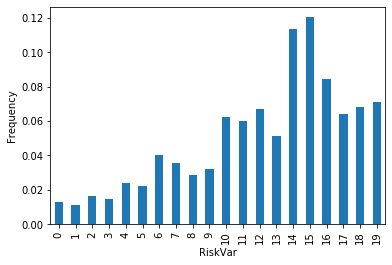

In [21]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [22]:
FreqCount

,Count,Freq
RiskVar,,
0,531,0.013036
1,451,0.011072
2,660,0.016203
3,603,0.014804
4,979,0.024035
5,902,0.022145
6,1634,0.040116
7,1439,0.035328
8,1170,0.028724


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [0]:
from sklearn.utils import class_weight

In [0]:
weights = class_weight.compute_class_weight('balanced',
                                                 df.RiskVar.unique(),
                                                 df.RiskVar)

In [0]:
def make_weight (row):
   return weights[int(row['RiskVar'])]

In [0]:
df['weight'] = df.apply (lambda row: make_weight(row), axis=1)

In [27]:
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,SocioCateg_CSP9,DrivAgeSq,weight
0,0.583,366,0,0,55,0,72,0.000000,14,0,0,0,1,0,1,0,0,0,0,0,0,0,3025,2.257871
1,0.200,187,1,1,34,0,80,0.000000,19,0,0,1,0,0,0,0,0,0,1,0,0,0,1156,4.515743
2,0.083,169,0,0,33,0,63,0.000000,16,0,0,0,1,0,1,0,0,0,0,0,0,0,1089,1.246389
3,0.375,170,0,0,34,0,63,0.000000,16,0,0,0,1,0,1,0,0,0,0,0,0,0,1156,1.246389
4,0.500,224,1,0,53,0,72,1418.610272,18,1,0,0,1,0,0,0,0,1,0,0,0,0,2809,3.377446


Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['RiskVar'], axis=1), df.RiskVar, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)


Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [29]:
xgb_train = xgb.DMatrix(x_train.drop(['Exposure'], axis=1), (y_train))
xgb_valid = xgb.DMatrix(x_valid.drop(['Exposure'], axis=1), (y_valid))
xgb_test = xgb.DMatrix(x_test.drop(['Exposure'], axis=1), (y_test))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [0]:
'<Ваш код здесь>'

'<Ваш код здесь>'

Далее обучим нашу модель с оптимальными параметрами

In [0]:
params = {'alpha': 0.9421394125156006,
 'eta': 0.25676315790889986,
 'lambda': 0.5666526532577569,
 'max_depth': 5,
 'min_child_weight': 49.383294309320455,
 'num_boost_round': 475.0,
 'objective': 'multi:softmax',
 'num_class': 20}

In [0]:
progress = dict()
xgb_model = xgb.train(params = params, dtrain=xgb_train, maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid"), (xgb_test, "test")], early_stopping_rounds=10, evals_result=progress, verbose_eval=False)

In [32]:
xgb_model.predict(xgb_test)

array([15.,  8., 16., ..., 14., 15., 18.], dtype=float32)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [33]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb_model.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'].values, class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 1.0
F1 Score on valid: 1.0
F1 Score on test: 1.0


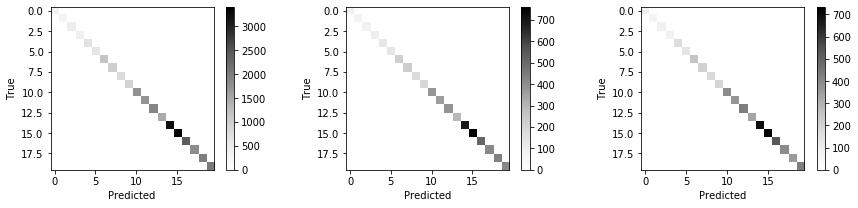

In [34]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_model.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Похоже, модель хорошо справляется со своей задачей, теперь попробуем отправить её в production.

In [35]:
!pip install flask-ngrok

In [0]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify

In [37]:
df.columns

Index(['Exposure', 'LicAge', 'Gender', 'MariStat', 'DrivAge', 'HasKmLimit',
       'BonusMalus', 'ClaimAmount', 'RiskVar', 'ClaimInd', 'VehUsage_Private',
       'VehUsage_Private+trip to office', 'VehUsage_Professional',
       'VehUsage_Professional run', 'SocioCateg_CSP1', 'SocioCateg_CSP2',
       'SocioCateg_CSP3', 'SocioCateg_CSP4', 'SocioCateg_CSP5',
       'SocioCateg_CSP6', 'SocioCateg_CSP7', 'SocioCateg_CSP9', 'DrivAgeSq',
       'weight'],
      dtype='object')

In [59]:
# Обработчики и запуск Flask

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

def map_for_dict_Gender(Gender):
  dict_Gender = {'Male':0, 'Female':1}
  res = dict_Gender.get(Gender)
  return res

def map_for_dict_MariStat(MariStat):
  dict_MariStat = {'Other':0, 'Alone':1}
  res = dict_MariStat.get(MariStat)
  return res

def f_VehUsage_Professional(VehUsage):
  if VehUsage == 'Professional':
    VehUsage_Professional = 1
  else:
    VehUsage_Professional = 0
  return(VehUsage_Professional)

def f_VehUsage_Private_trip_to_office(VehUsage):
  if VehUsage == 'Private+trip to office':
    VehUsage_Private_trip_to_office = 1
  else:
    VehUsage_Private_trip_to_office = 0
  return(VehUsage_Private_trip_to_office)

def f_VehUsage_Private(VehUsage):
  if VehUsage == 'Private':
    VehUsage_Private = 1
  else:
    VehUsage_Privatel = 0
  return(VehUsage_Private)

def f_VehUsage_Professional_run(VehUsage):
  if VehUsage == 'Professional run':
    VehUsage_Professional_run = 1
  else:
    VehUsage_Professional_run = 0
  return(VehUsage_Professional_run)


@app.route('/predict', methods=['GET', 'POST'])
def predict3():

    try:

      json_input = request.json

      ID = json_input["ID"]
      LicAge = json_input["LicAge"]
      Gender = map_for_dict_Gender(json_input["Gender"])
      MariStat = map_for_dict_MariStat(json_input["MariStat"])
      DrivAge = json_input["DrivAge"]
      HasKmLimit = json_input["HasKmLimit"]
      BonusMalus = json_input["BonusMalus"]
      VehUsg_Private = f_VehUsage_Private(json_input["VehUsage"])
      VehUsg_Private_trip_to_office = f_VehUsage_Private_trip_to_office(json_input["VehUsage"])
      VehUsg_Professional = f_VehUsage_Professional(json_input["VehUsage"])
      VehUsg_Professional_run = f_VehUsage_Professional_run(json_input["VehUsage"])
      DrivAgeSq = DrivAge ** 2

      X = np.array([[
            LicAge,
            Gender,
            MariStat,
            DrivAge,
            HasKmLimit,
            BonusMalus,
            VehUsg_Private,
            VehUsg_Private_trip_to_office,
            VehUsg_Professional,
            VehUsg_Professional_run,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            DrivAgeSq,
            0,
            0,
            0
      ]])


      columns = [
      'LicAge',
      'Gender',
      'MariStat',
      'DrivAge',
      'HasKmLimit',
      'BonusMalus',
      'VehUsg_Private',
      'VehUsg_Private+trip to office',
      'VehUsg_Professional',
      'VehUsg_Professional run',
      'SocioCateg_CSP1',
      'SocioCateg_CSP2',
      'SocioCateg_CSP3',
      'SocioCateg_CSP4',
      'SocioCateg_CSP5',
      'SocioCateg_CSP6',
      'SocioCateg_CSP7',
      'SocioCateg_CSP8',
      'SocioCateg_CSP9',
      'DrivAgeSq',
      'weight',
      'ClaimAmount',
      'ClaimInd'
      ]

      print(X)

      dtest = xgb.DMatrix(pd.DataFrame(X, columns=columns))
      print(dtest)

      res = xgb_model.predict(dtest)

      return jsonify({'prediction':res}) 
    
    except:
      
      return "Error"



if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://05a3207f.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [16/Feb/2020 10:20:39] "POST /predict HTTP/1.1" 200 -


[[ 468    0    0   67    0   50    1    0    0    0    0    0    0    0
     0    0    0    0    0 4489    0    0    0]]


127.0.0.1 - - [16/Feb/2020 10:20:50] "POST /predict HTTP/1.1" 200 -


[[ 468    0    0   67    0   50    1    0    0    0    0    0    0    0
     0    0    0    0    0 4489    0    0    0]]
